# Modelos de Redes Neuronales para Predicción de Demanda Eléctrica

Este notebook implementa y optimiza tres arquitecturas de redes neuronales profundas para la predicción de demanda eléctrica en España.

## Objetivo

Desarrollar modelos de Deep Learning que capturen patrones complejos y dependencias temporales en la demanda eléctrica, mejorando las versiones anteriores mediante:

- Optimización de arquitecturas
- Mejor regularización
- Ajuste de hiperparámetros
- Captura de patrones temporales extendidos

## Modelos Implementados

### 1. MLP Simplificado (Multi-Layer Perceptron)
Arquitectura de red neuronal totalmente conectada optimizada para datos tabulares, con enfoque en prevenir overfitting mediante:
- Reducción de capas (en la primera prueba con 4 capas hizo overfitting rapido, por lo que reducimos a 2)
- Regularización L2 en todas las capas
- Dropout incrementado
- Learning rate reducido

### 2. LSTM Optimizado (Long Short-Term Memory)
Red recurrente que captura dependencias temporales a largo plazo, con mejoras clave:
- Secuencias extendidas de 168 horas (1 semana completa)
- Captura de ciclos semanales y diferencias laborables vs fin de semana
- Arquitectura con doble LSTM y return_sequences
- Regularización mejorada

### 3. CNN-LSTM Mejorado (Convolutional Neural Network + LSTM)
Arquitectura híbrida que combina extracción automática de features con procesamiento secuencial:
- CNN profundo con 3 capas convolucionales
- Kernels más grandes para capturar patrones amplios
- Doble LSTM para procesar secuencias de features extraídas
- Regularización L2 completa

## Flujo de Trabajo

1. **Carga de datos**: Dataset de entrenamiento con features seleccionadas
2. **Preparación**: Normalización, creación de secuencias temporales, split train/test
3. **Entrenamiento**: Cada modelo con early stopping y reducción adaptativa de learning rate
4. **Evaluación**: Métricas MAE, RMSE, MAPE, R² en conjunto de test
5. **Comparación**: Análisis entre las tres arquitecturas de redes neuronales
6. **Guardado**: Exportación de modelos, scalers y predicciones

## Prerequisitos

- Notebook 02 (feature_engineering) ejecutado: Genera features_train.parquet y selected_features.json

## Métricas de Evaluación

- **MAE** (Mean Absolute Error): Error promedio en MW
- **RMSE** (Root Mean Squared Error): Penaliza errores grandes
- **MAPE** (Mean Absolute Percentage Error): Error porcentual
- **R²** (Coeficiente de determinación): Calidad del ajuste
- **Tiempo de entrenamiento**: Eficiencia computacional

## Instrucciones Completas para Google Colab, pues para local es pesado

### Preparación previa (en tu equipo local):

1. **Subir archivos necesarios a Google Drive:**
   - Mantener la estructura completa del proyecto en Google Drive
   - Estructura requerida:
     ```
     Google Drive/
     └── TFM/
         └── models/
             └── demand_forecast/
                 └── artifacts/
                     ├── data/
                     │   └── train_models/
                     │       └── features_train.parquet
                     └── analysis/
                         └── selected_features.json
     ```

2. **Copiar archivos desde tu proyecto local:**
   - Desde: `models/demand_forecast/artifacts/data/train_models/features_train.parquet`
   - Desde: `models/demand_forecast/artifacts/analysis/selected_features.json`

3. **Copiar este Notebook:**
   - Desde `models/demand_forecast/07_models_neural_networks.ipynb`

### Ejecución en Google Colab:

1. **Abrir este notebook en Colab:**
   - Ir a: https://colab.research.google.com
   - File > Upload notebook o File > Open notebook > GitHub/Google Drive

2. **Configurar GPU:**
   - Runtime > Change runtime type
   - Hardware accelerator: **GPU T4** (recomendado)
   - Save

3. **Ejecutar celdas en orden:**
   - La celda 3 montará Google Drive (autoriza el acceso)
   - La celda 3 verificará que tienes los archivos necesarios
   - Continúa ejecutando todas las celdas secuencialmente

4. **Al finalizar:**
   - La última celda copiará resultados a Google Drive
   - Opcionalmente descarga un ZIP al navegador

In [1]:
# ===================================================================
# CONFIGURACIÓN PARA GOOGLE COLAB
# ===================================================================
import os

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Ejecutando en Google Colab")
except ImportError:
    IN_COLAB = False
    print("Ejecutando en entorno local")

if IN_COLAB:
    print("\n" + "="*70)
    print("CONFIGURACIÓN DE GOOGLE COLAB CON GPU")
    print("="*70)

    # 1. Verificar GPU
    print("\n1. Verificando GPU disponible...")
    gpu_info = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
    if gpu_info:
        print(f"   GPU detectada: {gpu_info[0]}")
        if 'T4' in str(gpu_info):
            print("   GPU T4 correcta para Deep Learning")
        else:
            print("   ADVERTENCIA: Se recomienda GPU T4")
            print("   Ve a: Runtime > Change runtime type > Hardware accelerator = GPU")
    else:
        print("   ERROR: No se detectó GPU")
        print("   CONFIGURA GPU: Runtime > Change runtime type > Hardware accelerator = GPU")

    # 2. Montar Google Drive
    print("\n2. Montando Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("   Google Drive montado correctamente")

    # 3. Definir rutas base
    print("\n3. Configurando rutas de datos...")

    # Ruta base en Google Drive (estructura completa del proyecto)
    DRIVE_BASE = '/content/drive/MyDrive/TFM/models/demand_forecast'

    # Verificar que existe la carpeta en Drive
    if os.path.exists(DRIVE_BASE):
        print(f"   Carpeta encontrada: {DRIVE_BASE}")
    else:
        print(f"   ERROR: No se encontró {DRIVE_BASE}")
        print("   Asegúrate de tener la estructura completa:")
        print("   Google Drive/TFM/models/demand_forecast/artifacts/...")

    # Crear enlaces simbólicos o copiar estructura localmente
    print("\n4. Creando estructura de directorios local...")

    # Opción A: Trabajar directamente con Drive (más lento pero no usa espacio)
    # BASE_PATH = DRIVE_BASE

    # Opción B: Copiar a local de Colab (más rápido, usa espacio temporal)
    BASE_PATH = '/content/artifacts'

    # Verificar archivos necesarios en Drive
    archivos_necesarios = {
        'features_train.parquet': f'{DRIVE_BASE}/artifacts/data/train_models/features_train.parquet',
        'selected_features.json': f'{DRIVE_BASE}/artifacts/analysis/selected_features.json'
    }

    print("\n5. Verificando archivos en Google Drive...")
    archivos_ok = True
    for nombre, ruta in archivos_necesarios.items():
        if os.path.exists(ruta):
            size_mb = os.path.getsize(ruta) / (1024*1024)
            print(f"   OK - {nombre} ({size_mb:.2f} MB)")
        else:
            print(f"   FALTA - {nombre}")
            print(f"           Esperado en: {ruta}")
            archivos_ok = False

    if not archivos_ok:
        print("\n   ERROR: Faltan archivos en Google Drive")
        print("   Sube los archivos necesarios a Google Drive en:")
        print(f"   {DRIVE_BASE}/artifacts/data/train_models/features_train.parquet")
        print(f"   {DRIVE_BASE}/artifacts/analysis/selected_features.json")
        raise FileNotFoundError("Archivos necesarios no encontrados en Google Drive")

    # Crear estructura local y copiar archivos (para mejor rendimiento)
    print("\n6. Copiando archivos a almacenamiento local de Colab...")
    os.makedirs('/content/artifacts/data/train_models', exist_ok=True)
    os.makedirs('/content/artifacts/analysis', exist_ok=True)
    os.makedirs('/content/artifacts/trained_models', exist_ok=True)
    os.makedirs('/content/artifacts/data/predictions', exist_ok=True)

    # Copiar archivos
    !cp "{DRIVE_BASE}/artifacts/data/train_models/features_train.parquet" /content/artifacts/data/train_models/
    !cp "{DRIVE_BASE}/artifacts/analysis/selected_features.json" /content/artifacts/analysis/

    print("   Archivos copiados a /content/artifacts/")

    # Actualizar BASE_PATH para usar archivos locales
    BASE_PATH = '/content/artifacts'

    print("\n" + "="*70)
    print("CONFIGURACIÓN COMPLETADA")
    print("="*70)
    print(f"\nRuta de trabajo: {BASE_PATH}")
    print("Los resultados se guardarán localmente y luego se copiarán a Drive")
    print("\nPuedes continuar ejecutando las siguientes celdas")
    print("="*70)

else:
    # Ejecución local
    print("\nEjecución en entorno local")
    BASE_PATH = 'artifacts'
    print(f"Ruta de trabajo: {BASE_PATH}")
    print("Las rutas son relativas al directorio del notebook")

Ejecutando en Google Colab

CONFIGURACIÓN DE GOOGLE COLAB CON GPU

1. Verificando GPU disponible...
   GPU detectada: Tesla T4, 15360 MiB
   GPU T4 correcta para Deep Learning

2. Montando Google Drive...
Mounted at /content/drive
   Google Drive montado correctamente

3. Configurando rutas de datos...
   Carpeta encontrada: /content/drive/MyDrive/TFM/models/demand_forecast

4. Creando estructura de directorios local...

5. Verificando archivos en Google Drive...
   OK - features_train.parquet (3.14 MB)
   OK - selected_features.json (0.00 MB)

6. Copiando archivos a almacenamiento local de Colab...
   Archivos copiados a /content/artifacts/

CONFIGURACIÓN COMPLETADA

Ruta de trabajo: /content/artifacts
Los resultados se guardarán localmente y luego se copiarán a Drive

Puedes continuar ejecutando las siguientes celdas


In [2]:
# Importar SOLO bibliotecas básicas (rápido <1s)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import joblib
import time
import os

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('default')
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Sklearn (rápido)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

print("Bibliotecas básicas cargadas")
print("Keras/TensorFlow se cargará en la siguiente celda cuando sea necesario")

Bibliotecas básicas cargadas
Keras/TensorFlow se cargará en la siguiente celda cuando sea necesario


## Configuración de Fechas de Entrenamiento

Define el rango de fechas para entrenamiento.

**Nota**: Estos valores pueden ser sobrescritos por el Notebook 00 (Pipeline Maestro) cuando se ejecuta automáticamente.

In [3]:
# PARÁMETROS - Esta celda puede ser sobrescrita por papermill (NB00)
# Si ejecutas este notebook manualmente, modifica estos valores aquí
# Si lo ejecutas desde NB00, estos valores serán reemplazados automáticamente

# Configuración de fechas de entrenamiento
# None = usar todos los datos disponibles desde el inicio
FECHA_INICIO_ENTRENAMIENTO = None
# Por defecto: hasta el 2025-09-20 (puedes cambiarlo según necesites)
FECHA_FIN_ENTRENAMIENTO = pd.Timestamp('2025-09-20 23:59:59')

In [4]:
# Mostrar configuración activa
print("="*80)
print("CONFIGURACIÓN DE FECHAS ACTIVA (NB07 - Neural Networks)")
print("="*80)
print(f"Inicio: {'Desde el principio' if FECHA_INICIO_ENTRENAMIENTO is None else FECHA_INICIO_ENTRENAMIENTO}")
print(f"Fin:    {FECHA_FIN_ENTRENAMIENTO}")
print("="*80)

CONFIGURACIÓN DE FECHAS ACTIVA (NB07 - Neural Networks)
Inicio: Desde el principio
Fin:    2025-09-20 23:59:59


## Carga de Datos

In [5]:
# Cargar datos (usa BASE_PATH configurado en celda anterior)
df = pd.read_parquet(f'{BASE_PATH}/data/train_models/features_train.parquet')

# Aplicar filtros de fecha si están configurados
if FECHA_INICIO_ENTRENAMIENTO is not None:
    df = df[df['datetime'] >= FECHA_INICIO_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos desde {FECHA_INICIO_ENTRENAMIENTO}")

if FECHA_FIN_ENTRENAMIENTO is not None:
    df = df[df['datetime'] <= FECHA_FIN_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos hasta {FECHA_FIN_ENTRENAMIENTO}")

# Cargar features seleccionadas
with open(f'{BASE_PATH}/analysis/selected_features.json', 'r') as f:
    selected_features_data = json.load(f)
    selected_features = selected_features_data['features']

print(f"\nDataset cargado: {len(df):,} registros")
print(f"Features seleccionadas: {len(selected_features)}")

Aplicando filtro: datos hasta 2025-09-20 23:59:59

Dataset cargado: 23,856 registros
Features seleccionadas: 29


## Preparación de Datos

In [6]:
# Split train/test
fecha_corte = df['datetime'].max() - pd.DateOffset(months=2)
df_train = df[df['datetime'] < fecha_corte].copy()
df_test = df[df['datetime'] >= fecha_corte].copy()

# Filtrar features disponibles
available_features = [f for f in selected_features if f in df.columns]
print(f"Features disponibles: {len(available_features)}")

# Preparar datos
df_train_clean = df_train[available_features + ['demanda', 'datetime']].dropna()
df_test_clean = df_test[available_features + ['demanda', 'datetime']].dropna()

X_train_full = df_train_clean[available_features].values
y_train_full = df_train_clean['demanda'].values
X_test = df_test_clean[available_features].values
y_test = df_test_clean['demanda'].values

print(f"\nDatos preparados:")
print(f"  X_train: {X_train_full.shape}")
print(f"  X_test: {X_test.shape}")

# Normalizar (crítico para redes neuronales)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_full)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_full.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print("\nDatos normalizados correctamente")

Features disponibles: 29

Datos preparados:
  X_train: (22151, 29)
  X_test: (1489, 29)

Datos normalizados correctamente


## Carga de Keras/TensorFlow

**Esta celda carga las librerías de Deep Learning** (puede tardar 10-30s en Apple M3)

In [7]:
# Configurar entorno de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['KERAS_BACKEND'] = 'tensorflow'

print("Cargando Keras/TensorFlow...")
start = time.time()

# Importar Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

elapsed = time.time() - start
print(f"Keras/TensorFlow listo en {elapsed:.1f}s")

Cargando Keras/TensorFlow...
Keras/TensorFlow listo en 3.0s


## Funciones de Evaluación

In [8]:
def evaluar_modelo(y_true, y_pred, nombre_modelo="", tiempo_entrenamiento=None):
    """Evalúa el rendimiento del modelo"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n{'='*60}")
    print(f"Resultados: {nombre_modelo}")
    print(f"{'='*60}")
    print(f"MAE:  {mae:,.2f} MW")
    print(f"RMSE: {rmse:,.2f} MW")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")
    if tiempo_entrenamiento:
        print(f"Tiempo: {tiempo_entrenamiento:.2f}s")
    print(f"{'='*60}")

    return {
        'modelo': nombre_modelo,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'tiempo_entrenamiento': tiempo_entrenamiento
    }

def plot_predictions(y_true, y_pred, title="", n_samples=168):
    """Visualiza predicciones"""
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].plot(y_true[:n_samples], label='Real', linewidth=2)
    axes[0].plot(y_pred[:n_samples], label='Predicción', linestyle='--', linewidth=2)
    axes[0].set_title(f'{title} - Primera Semana')
    axes[0].set_xlabel('Horas')
    axes[0].set_ylabel('Demanda (MW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    errors = y_true[:n_samples] - y_pred[:n_samples]
    axes[1].plot(errors, color='red', linewidth=1.5)
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].fill_between(range(len(errors)), errors, alpha=0.3, color='red')
    axes[1].set_title('Error de Predicción')
    axes[1].set_xlabel('Horas')
    axes[1].set_ylabel('Error (MW)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_history(history, title=""):
    """Visualiza historial de entrenamiento"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_title(f'{title} - MAE')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Almacenar resultados
resultados_modelos = []

## 1. MLP Mejorado - Arquitectura Simplificada

### Cambios respecto a versión anterior:
```
# Versión 06 original:
# - Arquitectura: 256 → 128 → 64 → 32 (4 capas ocultas) → OVERFITTING
# - Dropout: 0.2
# - Sin regularización L2
# - Learning rate: 0.001
# - Resultado: MAE: 605.13 MW, R²: 0.9613
# - Problema: Excesiva complejidad para datos tabulares, sobreajuste visible
```

### Mejoras implementadas:
- Arquitectura simplificada: 128 → 64 (solo 2 capas)
- Dropout aumentado: 0.3 (primera capa), 0.2 (segunda)
- Regularización L2: 0.001 en todas las capas densas
- Learning rate reducido: 0.0005
- Objetivo: Reducir overfitting y mejorar generalización


ENTRENANDO MLP

Arquitectura del modelo:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando...
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.9603 - mae: 0.7033 - val_loss: 0.2262 - val_mae: 0.2380 - learning_rate: 5.0000e-04
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3546 - mae: 0.3679 - val_loss: 0.1947 - val_mae: 0.1983 - learning_rate: 5.0000e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2935 - mae: 0.3152 - val_loss: 0.1772 - val_mae: 0.1765 - learning_rate: 5.0000e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2573 - mae: 0.2834 - val_loss: 0.1676 - val_mae: 0.1668 - learning_rate: 5.0000e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2369 - mae: 0.2646 - val_loss: 0.1609 - val_mae: 0.1615 - learning_rate: 5.0000e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2174 - mae: 0.2452 - val_loss: 0.1550 - val_mae: 0.1568 - learning_rate: 5.0000e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2066 - mae: 0.2359 - val_loss: 0.1514 - val_mae: 0.15

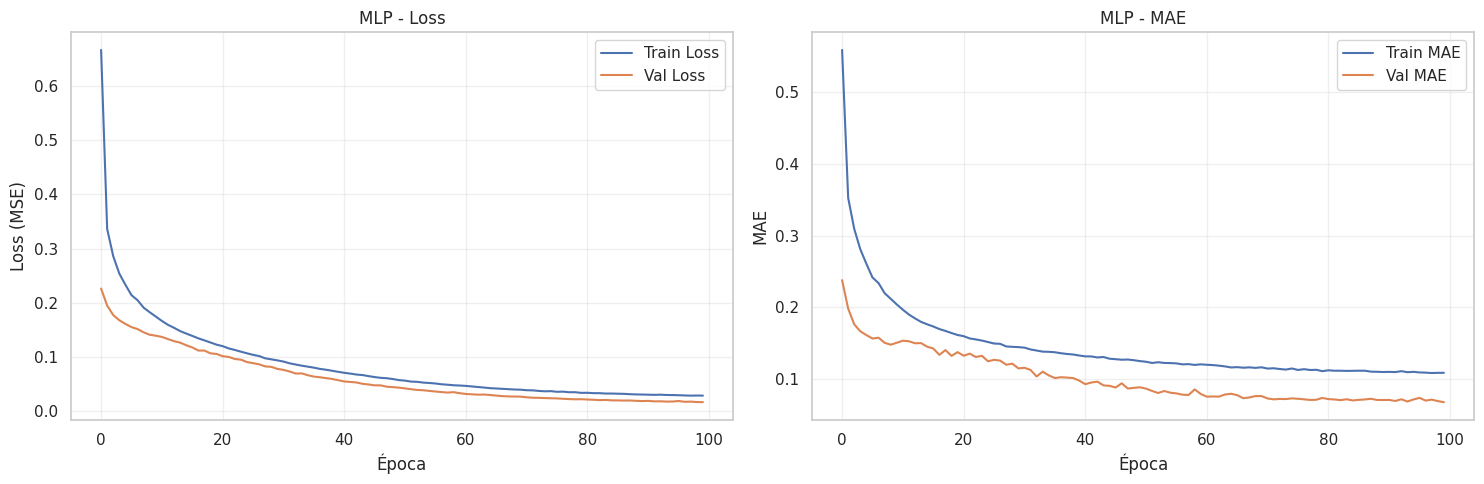

In [9]:
print("\n" + "="*60)
print("ENTRENANDO MLP")
print("="*60)

# Crear modelo MLP SIMPLIFICADO
mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
], name='MLP')

mlp_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print("\nArquitectura del modelo:")
mlp_model.summary()

# Callbacks mejorados
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

# Entrenar
print("\nEntrenando...")
start_time = time.time()

mlp_history = mlp_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=512,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

mlp_train_time = time.time() - start_time
print(f"\nModelo entrenado en {mlp_train_time:.2f}s")
print(f"Épocas ejecutadas: {len(mlp_history.history['loss'])}")
print(f"Mejor época: {len(mlp_history.history['loss']) - 15}")

# Visualizar historial
plot_history(mlp_history, "MLP")


Rendimiento en TRAIN:

Resultados: MLP (Train)
MAE:  268.88 MW
RMSE: 362.57 MW
MAPE: 0.95%
R²:   0.9936

Rendimiento en TEST:

Resultados: MLP (Test)
MAE:  271.21 MW
RMSE: 352.16 MW
MAPE: 0.90%
R²:   0.9915
Tiempo: 25.72s


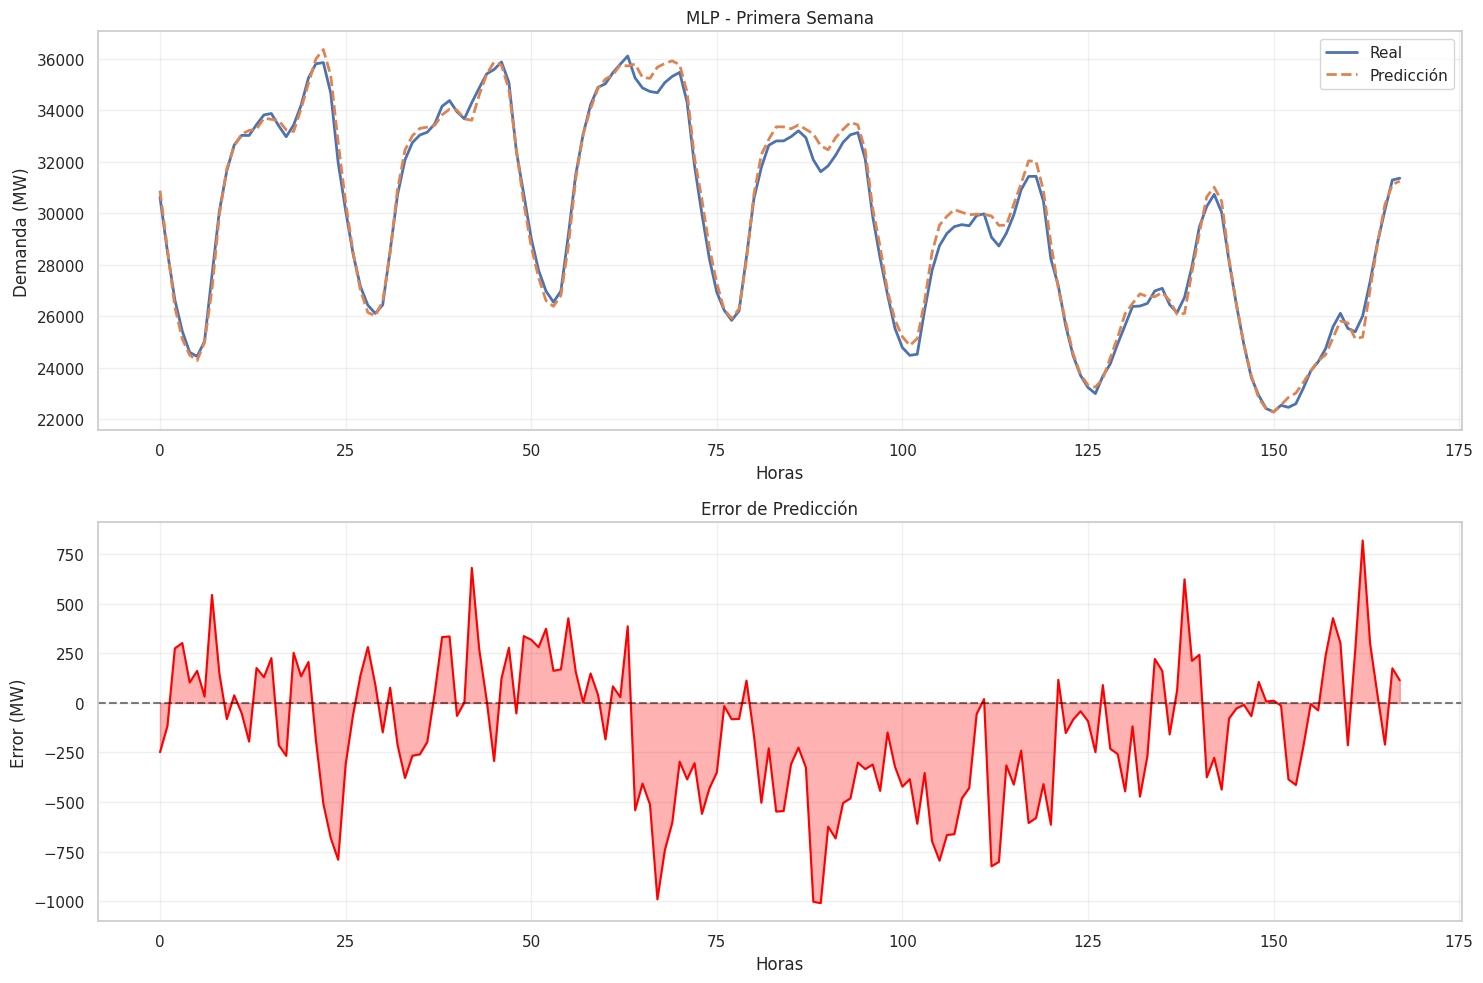

In [10]:
# Predicciones MLP
mlp_pred_train_scaled = mlp_model.predict(X_train_scaled, verbose=0)
mlp_pred_test_scaled = mlp_model.predict(X_test_scaled, verbose=0)

# Desnormalizar
mlp_pred_train = scaler_y.inverse_transform(mlp_pred_train_scaled).ravel()
mlp_pred_test = scaler_y.inverse_transform(mlp_pred_test_scaled).ravel()

# Evaluar
print("\nRendimiento en TRAIN:")
mlp_results_train = evaluar_modelo(y_train_full, mlp_pred_train, "MLP (Train)")

print("\nRendimiento en TEST:")
mlp_results_test = evaluar_modelo(y_test, mlp_pred_test, "MLP (Test)", mlp_train_time)
resultados_modelos.append(mlp_results_test)

# Visualizar
plot_predictions(y_test, mlp_pred_test, "MLP")

## 2. LSTM Mejorado - Secuencias Largas


In [11]:
# Preparar secuencias para LSTM
def create_sequences(X, y, seq_length=168):
    """Crea secuencias temporales para LSTM"""
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LENGTH = 168

print(f"Creando secuencias de longitud {SEQ_LENGTH} horas (1 semana)...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

# Desnormalizar targets para evaluación
y_train_seq_orig = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1)).ravel()
y_test_seq_orig = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

print(f"\nSecuencias creadas:")
print(f"  X_train_seq: {X_train_seq.shape}")
print(f"  X_test_seq: {X_test_seq.shape}")
print(f"\nCada muestra usa las últimas {SEQ_LENGTH} horas (7 días) para predecir la hora siguiente")
print(f"Esto permite capturar:")
print(f"  - Patrones diarios (24h)")
print(f"  - Ciclos semanales completos")
print(f"  - Diferencias laborables vs fin de semana")

Creando secuencias de longitud 168 horas (1 semana)...

Secuencias creadas:
  X_train_seq: (21983, 168, 29)
  X_test_seq: (1321, 168, 29)

Cada muestra usa las últimas 168 horas (7 días) para predecir la hora siguiente
Esto permite capturar:
  - Patrones diarios (24h)
  - Ciclos semanales completos
  - Diferencias laborables vs fin de semana



ENTRENANDO LSTM

Arquitectura del modelo:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 128)       │        80,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,417 (517.25 KB)

 Trainable params: 132,417 (517.25 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6041 - mae: 0.4800 - val_loss: 0.2323 - val_mae: 0.2057 - learning_rate: 5.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2109 - mae: 0.1937 - val_loss: 0.1576 - val_mae: 0.1624 - learning_rate: 5.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1483 - mae: 0.1652 - val_loss: 0.1208 - val_mae: 0.1527 - learning_rate: 5.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1139 - mae: 0.1530 - val_loss: 0.1015 - val_mae: 0.1505 - learning_rate: 5.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0938 - mae: 0.1450 - val_loss: 0.0871 - val_mae: 0.1466 - learning_rate: 5.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0802 - mae: 0.1430 - val_loss: 0.0785 - val_mae: 0.1471 - learning_rate: 5.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0694 - mae: 0.1357 - val_loss: 0.0690 - 

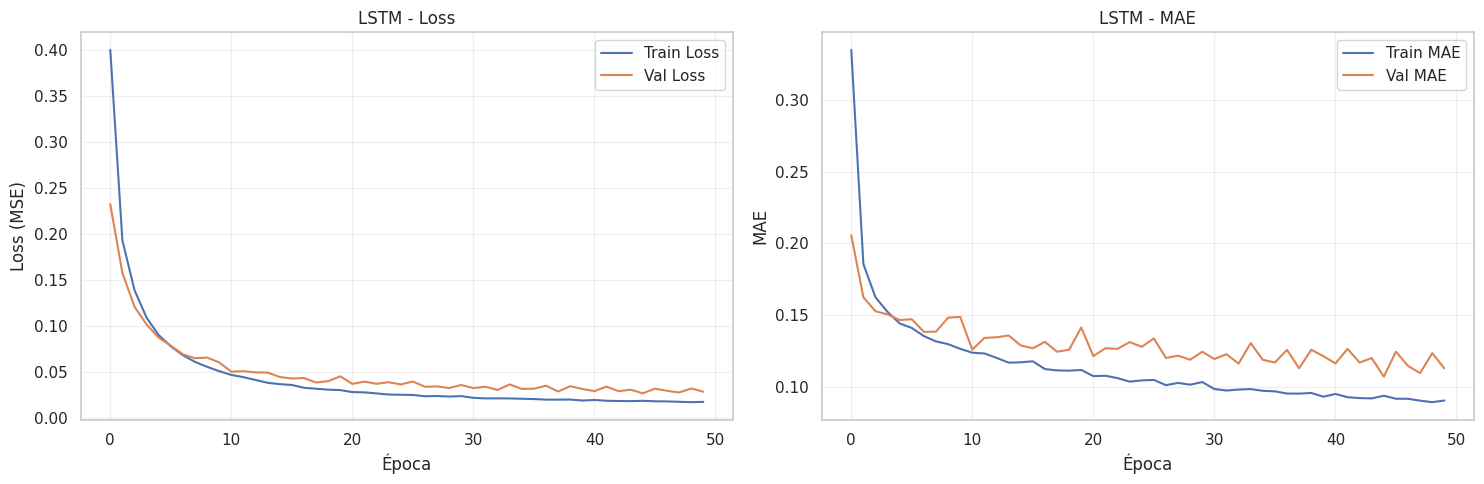

In [12]:
print("\n" + "="*60)
print("ENTRENANDO LSTM")
print("="*60)

# Crear modelo LSTM
lstm_model = Sequential([
    Input(shape=(SEQ_LENGTH, X_train_scaled.shape[1])),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
], name='LSTM')

lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print("\nArquitectura del modelo:")
lstm_model.summary()

# Entrenar
print("\nEntrenando...")
start_time = time.time()

lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

lstm_train_time = time.time() - start_time
print(f"\nModelo entrenado en {lstm_train_time:.2f}s")
print(f"Épocas ejecutadas: {len(lstm_history.history['loss'])}")
print(f"Mejor época: {len(lstm_history.history['loss']) - 15}")

# Visualizar historial
plot_history(lstm_history, "LSTM")


Rendimiento en TRAIN:

Resultados: LSTM (Train)
MAE:  351.82 MW
RMSE: 480.90 MW
MAPE: 1.24%
R²:   0.9887

Rendimiento en TEST:

Resultados: LSTM (Test)
MAE:  406.48 MW
RMSE: 519.87 MW
MAPE: 1.35%
R²:   0.9814
Tiempo: 173.61s


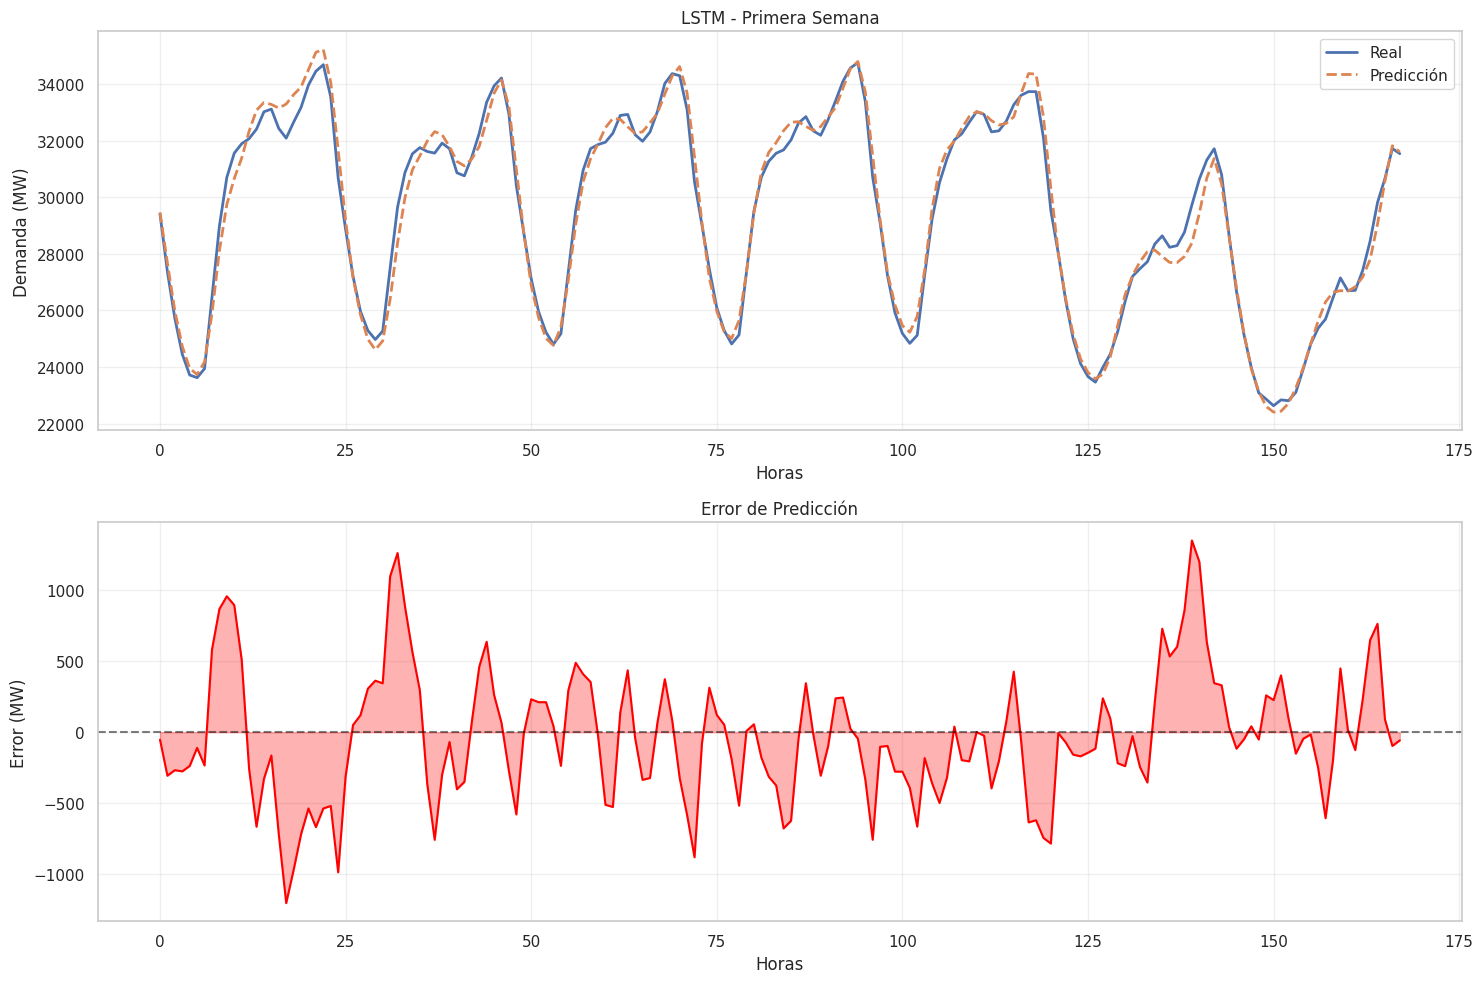

In [13]:
# Predicciones LSTM
lstm_pred_train_scaled = lstm_model.predict(X_train_seq, verbose=0)
lstm_pred_test_scaled = lstm_model.predict(X_test_seq, verbose=0)

# Desnormalizar
lstm_pred_train = scaler_y.inverse_transform(lstm_pred_train_scaled).ravel()
lstm_pred_test = scaler_y.inverse_transform(lstm_pred_test_scaled).ravel()

# Evaluar
print("\nRendimiento en TRAIN:")
lstm_results_train = evaluar_modelo(y_train_seq_orig, lstm_pred_train, "LSTM (Train)")

print("\nRendimiento en TEST:")
lstm_results_test = evaluar_modelo(y_test_seq_orig, lstm_pred_test, "LSTM (Test)", lstm_train_time)
resultados_modelos.append(lstm_results_test)

# Visualizar
plot_predictions(y_test_seq_orig, lstm_pred_test, "LSTM")


ENTRENANDO CNN-LSTM 

Arquitectura del modelo:


Model: "CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 168, 128)       │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 168, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 84, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 84, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 84, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8237 - mae: 0.5285 - val_loss: 0.3478 - val_mae: 0.2163 - learning_rate: 5.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3024 - mae: 0.1817 - val_loss: 0.2443 - val_mae: 0.1555 - learning_rate: 5.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2225 - mae: 0.1466 - val_loss: 0.1994 - val_mae: 0.1474 - learning_rate: 5.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1804 - mae: 0.1337 - val_loss: 0.1834 - val_mae: 0.1734 - learning_rate: 5.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1516 - mae: 0.1260 - val_loss: 0.1482 - val_mae: 0.1394 - learning_rate: 5.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1315 - mae: 0.1242 - val_loss: 0.1346 - val_mae: 0.1434 - learning_rate: 5.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1150 - mae: 0.1199 - val_loss: 0.1154 - 

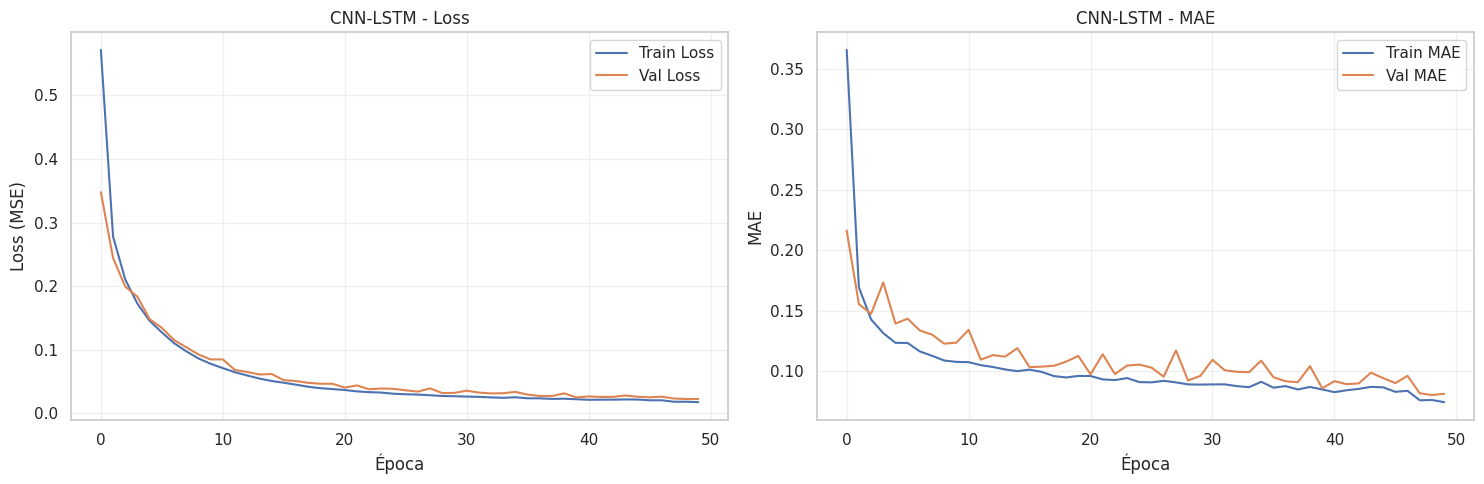

In [14]:
print("\n" + "="*60)
print("ENTRENANDO CNN-LSTM ")
print("="*60)

# Crear modelo CNN-LSTM
cnn_lstm_model = Sequential([
    Input(shape=(SEQ_LENGTH, X_train_scaled.shape[1])),

    # Definimos capas CNN
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),

    # Doble LSTM
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
], name='CNN_LSTM')

cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print("\nArquitectura del modelo:")
cnn_lstm_model.summary()

# Entrenar
print("\nEntrenando...")
start_time = time.time()

cnn_lstm_history = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

cnn_lstm_train_time = time.time() - start_time
print(f"\nModelo entrenado en {cnn_lstm_train_time:.2f}s")
print(f"Épocas ejecutadas: {len(cnn_lstm_history.history['loss'])}")
print(f"Mejor época: {len(cnn_lstm_history.history['loss']) - 15}")

# Visualizar historial
plot_history(cnn_lstm_history, "CNN-LSTM")


Rendimiento en TRAIN:

Resultados: CNN-LSTM (Train)
MAE:  273.63 MW
RMSE: 379.74 MW
MAPE: 0.98%
R²:   0.9930

Rendimiento en TEST:

Resultados: CNN-LSTM (Test)
MAE:  304.68 MW
RMSE: 397.02 MW
MAPE: 1.03%
R²:   0.9892
Tiempo: 142.99s


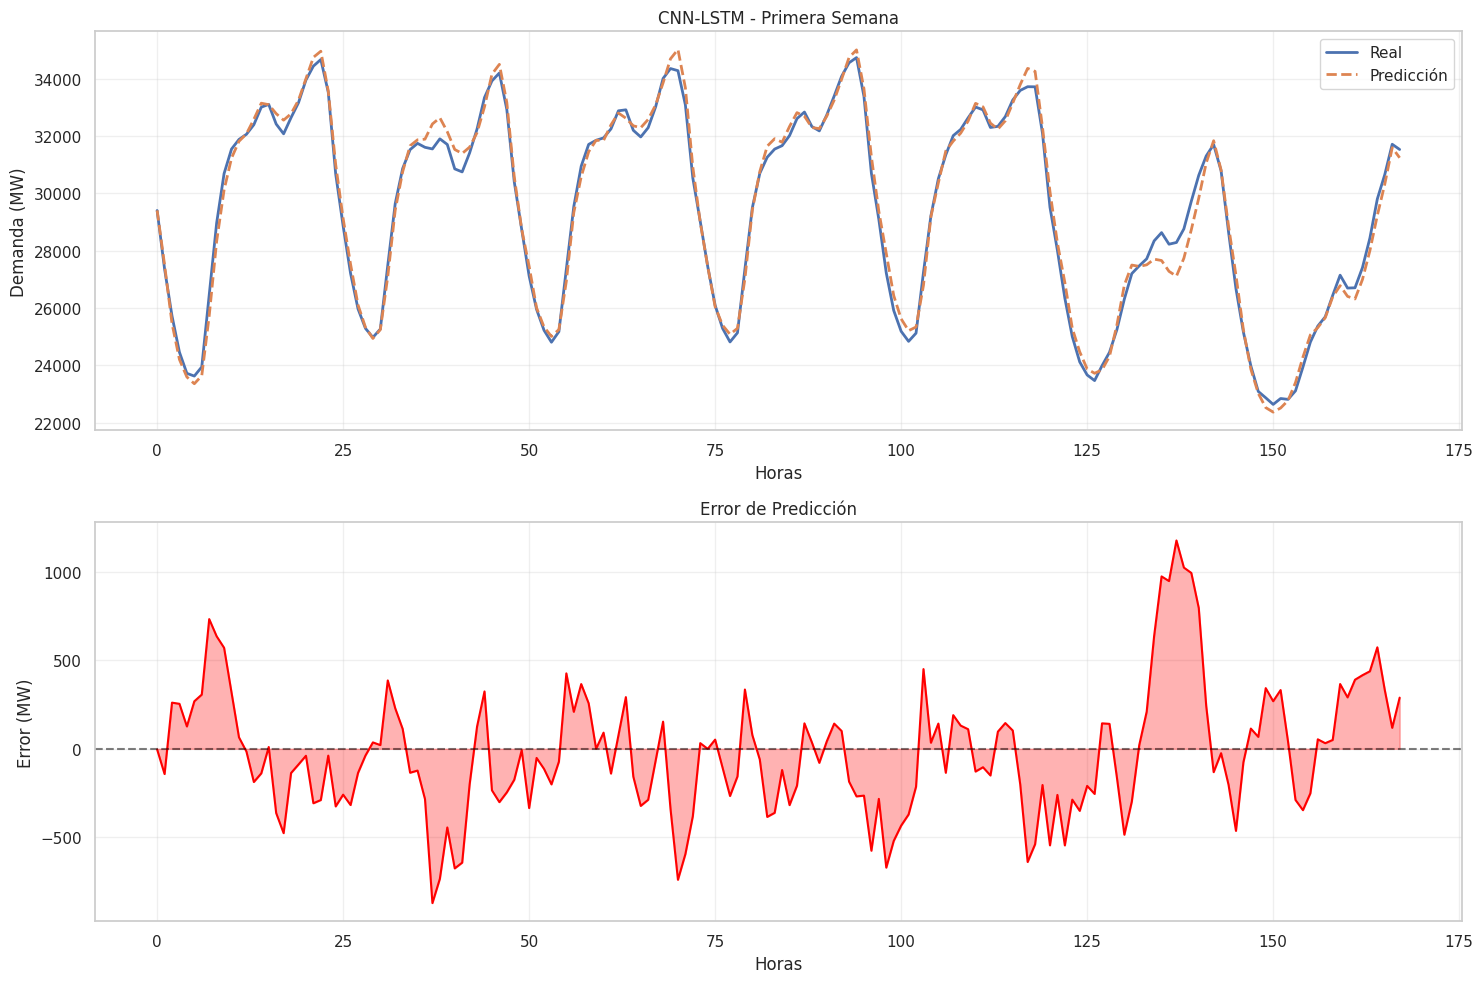

In [15]:
# Predicciones CNN-LSTM
cnn_lstm_pred_train_scaled = cnn_lstm_model.predict(X_train_seq, verbose=0)
cnn_lstm_pred_test_scaled = cnn_lstm_model.predict(X_test_seq, verbose=0)

# Desnormalizar
cnn_lstm_pred_train = scaler_y.inverse_transform(cnn_lstm_pred_train_scaled).ravel()
cnn_lstm_pred_test = scaler_y.inverse_transform(cnn_lstm_pred_test_scaled).ravel()

# Evaluar
print("\nRendimiento en TRAIN:")
cnn_lstm_results_train = evaluar_modelo(y_train_seq_orig, cnn_lstm_pred_train, "CNN-LSTM (Train)")

print("\nRendimiento en TEST:")
cnn_lstm_results_test = evaluar_modelo(y_test_seq_orig, cnn_lstm_pred_test, "CNN-LSTM (Test)", cnn_lstm_train_time)
resultados_modelos.append(cnn_lstm_results_test)


# Visualizar
plot_predictions(y_test_seq_orig, cnn_lstm_pred_test, "CNN-LSTM")

## Resumen de Resultados

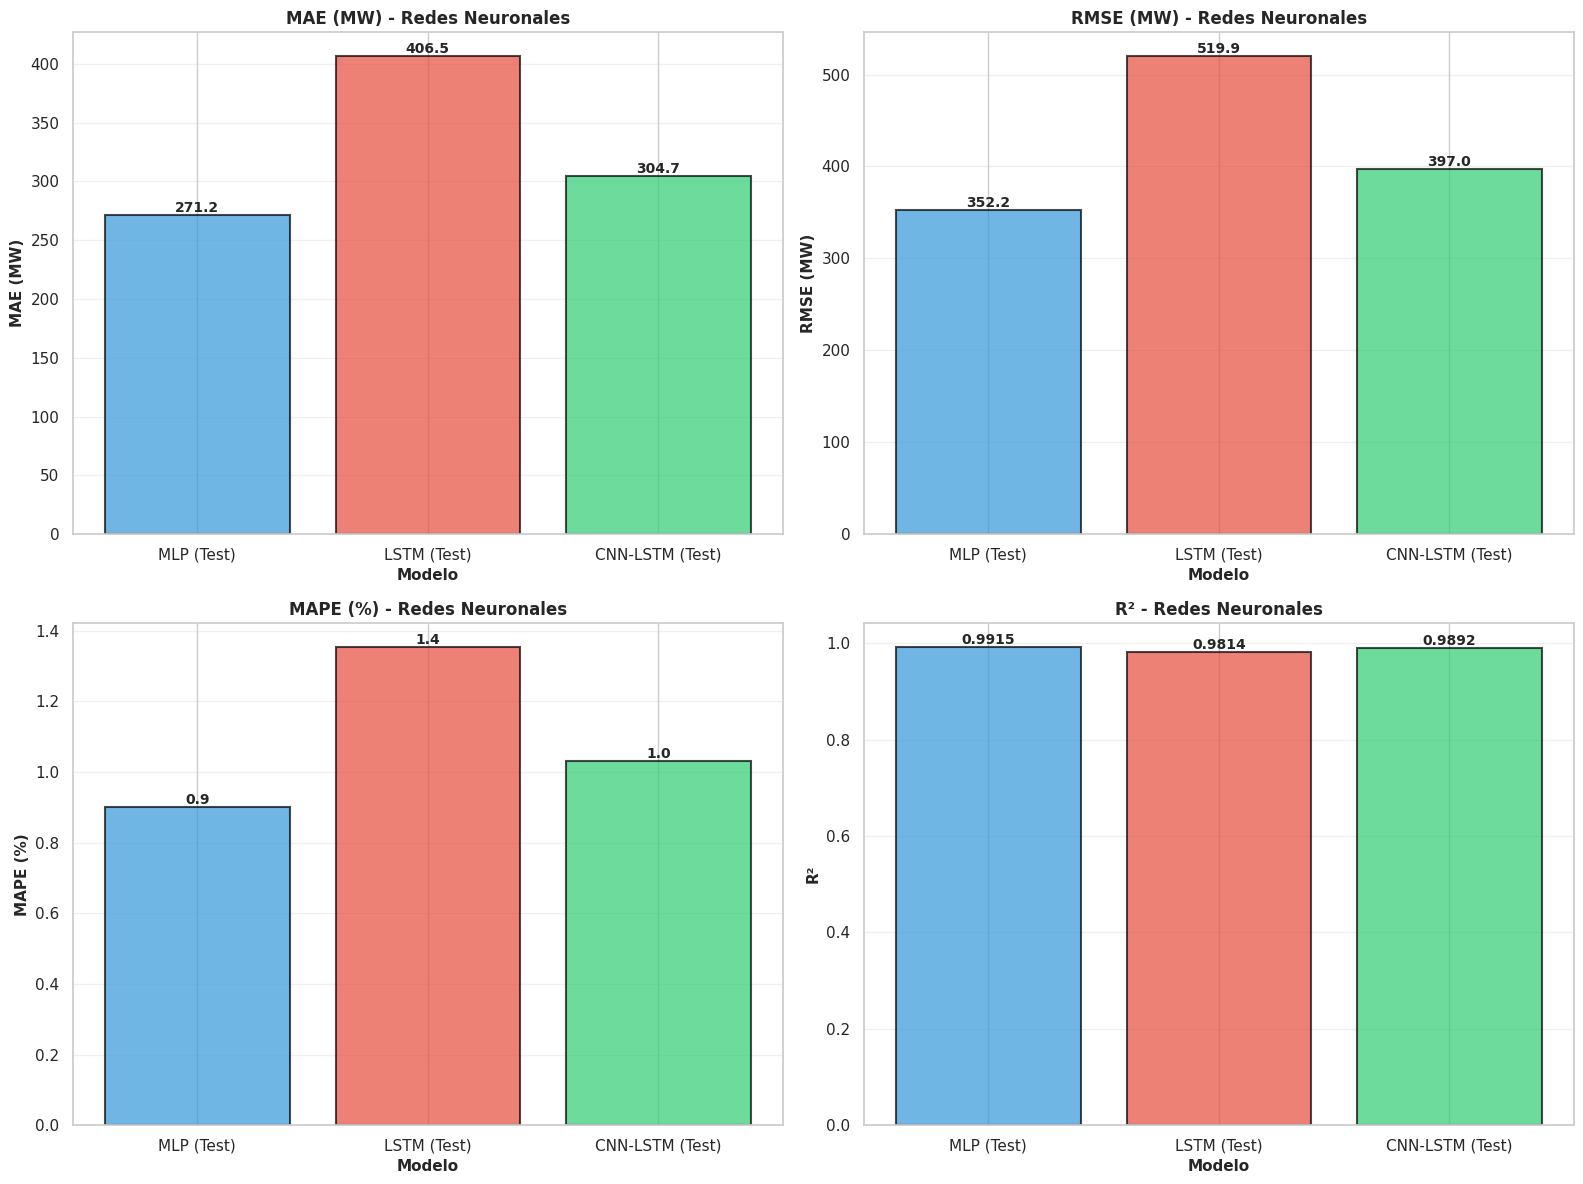

Gráfico guardado en: /content/artifacts/analysis/neural_models_results.png


In [16]:
# Crear DataFrame con resultados
resultados_df = pd.DataFrame(resultados_modelos)

# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['mae', 'rmse', 'mape', 'r2']
titles = ['MAE (MW)', 'RMSE (MW)', 'MAPE (%)', 'R²']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]

    # Datos
    valores = resultados_df[metric].values
    modelos = [m.replace(' Mejorado (Test)', '') for m in resultados_df['modelo'].values]

    # Barras
    bars = ax.bar(modelos, valores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Modelo', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} - Redes Neuronales', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)

    # Valores en barras
    for bar in bars:
        height = bar.get_height()
        if metric == 'r2':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/analysis/neural_models_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Gráfico guardado en: {BASE_PATH}/analysis/neural_models_results.png")

## Guardar Modelos y Resultados

In [17]:
# Crear directorios
models_dir = Path(f'{BASE_PATH}/trained_models')
models_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelos de Keras
print("Guardando modelos...")
mlp_model.save(models_dir / 'mlp_model.keras')
print("  - MLP guardado")

lstm_model.save(models_dir / 'lstm_model.keras')
print("  - LSTM guardado")

cnn_lstm_model.save(models_dir / 'cnn_lstm_model.keras')
print("  - CNN-LSTM guardado")

# Guardar scalers
joblib.dump(scaler_X, models_dir / 'scaler_X_neural.pkl')
joblib.dump(scaler_y, models_dir / 'scaler_y_neural.pkl')
print("  - Scalers guardados")

# Guardar configuración de secuencias
with open(models_dir / 'seq_config.json', 'w') as f:
    json.dump({'seq_length': SEQ_LENGTH}, f, indent=2)
print("  - Configuración de secuencias guardada")

# Guardar predicciones
predictions_dir = Path(f'{BASE_PATH}/data/predictions')
predictions_dir.mkdir(parents=True, exist_ok=True)

# MLP usa todos los puntos (no requiere secuencias)
predictions_mlp = pd.DataFrame({
    'datetime': df_test_clean['datetime'].values,
    'demanda_real': y_test,
    'pred_mlp': mlp_pred_test
})
predictions_mlp.to_parquet(predictions_dir / 'neural_mlp_predictions.parquet')

# LSTM y CNN-LSTM usan secuencias (168h de historia)
predictions_seq = pd.DataFrame({
    'datetime': df_test_clean['datetime'].values[SEQ_LENGTH:],
    'demanda_real': y_test_seq_orig,
    'pred_lstm': lstm_pred_test,
    'pred_cnn_lstm': cnn_lstm_pred_test
})
predictions_seq.to_parquet(predictions_dir / 'neural_seq_predictions.parquet')
print(f"\nPredicciones guardadas en: {BASE_PATH}/data/predictions/")

# Guardar resultados finales
resultados_df.to_csv(models_dir / 'neural_models_results.csv', index=False)
print(f"Resultados guardados en: {BASE_PATH}/trained_models/neural_models_results.csv")

print("\n" + "="*80)
print("NOTEBOOK COMPLETADO - REDES NEURONALES")
print("="*80)
print(f"\nModelos entrenados: {len(resultados_df)}")
print(f"Tiempo total de entrenamiento: {resultados_df['tiempo_entrenamiento'].sum():.2f}s")
print(f"\nMejor modelo: {resultados_df.nsmallest(1, 'mae').iloc[0]['modelo']}")
print(f"MAE: {resultados_df.nsmallest(1, 'mae').iloc[0]['mae']:.2f} MW")
print(f"\nArchivos generados:")
print(f"  - {BASE_PATH}/trained_models/mlp_model.keras")
print(f"  - {BASE_PATH}/trained_models/lstm_model.keras")
print(f"  - {BASE_PATH}/trained_models/cnn_lstm_model.keras")
print(f"  - {BASE_PATH}/trained_models/neural_models_results.csv")
print(f"  - {BASE_PATH}/data/predictions/neural_*.parquet")
print(f"  - {BASE_PATH}/analysis/neural_models_mejorados_results.png")

Guardando modelos...
  - MLP guardado
  - LSTM guardado
  - CNN-LSTM guardado
  - Scalers guardados
  - Configuración de secuencias guardada

Predicciones guardadas en: /content/artifacts/data/predictions/
Resultados guardados en: /content/artifacts/trained_models/neural_models_results.csv

NOTEBOOK COMPLETADO - REDES NEURONALES

Modelos entrenados: 3
Tiempo total de entrenamiento: 342.32s

Mejor modelo: MLP (Test)
MAE: 271.21 MW

Archivos generados:
  - /content/artifacts/trained_models/mlp_model.keras
  - /content/artifacts/trained_models/lstm_model.keras
  - /content/artifacts/trained_models/cnn_lstm_model.keras
  - /content/artifacts/trained_models/neural_models_results.csv
  - /content/artifacts/data/predictions/neural_*.parquet
  - /content/artifacts/analysis/neural_models_mejorados_results.png


## Descarga de Resultados desde Google Colab

Si ejecutaste este notebook en Google Colab, los resultados se guardaron en el almacenamiento temporal de Colab. Esta celda los copiará de vuelta a tu Google Drive.

In [18]:
# ===================================================================
# DESCARGA DE RESULTADOS A GOOGLE DRIVE
# ===================================================================
# Esta celda copia los resultados de vuelta a Google Drive

if IN_COLAB:
    print("\n" + "="*70)
    print("COPIANDO RESULTADOS A GOOGLE DRIVE")
    print("="*70)

    # Verificar que DRIVE_BASE existe
    if not 'DRIVE_BASE' in globals():
        DRIVE_BASE = '/content/drive/MyDrive/TFM/models/demand_forecast'

    # Crear directorios en Drive si no existen
    print("\n1. Verificando estructura de directorios en Drive...")
    !mkdir -p "{DRIVE_BASE}/artifacts/trained_models"
    !mkdir -p "{DRIVE_BASE}/artifacts/data/predictions"
    !mkdir -p "{DRIVE_BASE}/artifacts/analysis"
    print("   Directorios verificados")

    # Copiar modelos entrenados
    print("\n2. Copiando modelos entrenados (.keras)...")
    !cp /content/artifacts/trained_models/mlp_model.keras "{DRIVE_BASE}/artifacts/trained_models/"
    !cp /content/artifacts/trained_models/lstm_model.keras "{DRIVE_BASE}/artifacts/trained_models/"
    !cp /content/artifacts/trained_models/cnn_lstm_model.keras "{DRIVE_BASE}/artifacts/trained_models/"
    print("   3 modelos .keras copiados")

    # Copiar scalers
    print("\n3. Copiando scalers (.pkl)...")
    !cp /content/artifacts/trained_models/scaler_X_neural.pkl "{DRIVE_BASE}/artifacts/trained_models/"
    !cp /content/artifacts/trained_models/scaler_y_neural.pkl "{DRIVE_BASE}/artifacts/trained_models/"
    print("   2 scalers copiados")

    # Copiar configuración
    print("\n4. Copiando configuración (seq_config.json)...")
    !cp /content/artifacts/trained_models/seq_config.json "{DRIVE_BASE}/artifacts/trained_models/"
    print("   Configuración copiada")

    # Copiar resultados CSV
    print("\n5. Copiando resultados (.csv)...")
    !cp /content/artifacts/trained_models/neural_models_results.csv "{DRIVE_BASE}/artifacts/trained_models/"
    print("   Resultados CSV copiados")

    # Copiar predicciones
    print("\n6. Copiando predicciones (.parquet)...")
    !cp /content/artifacts/predictions/neural_mlp_predictions.parquet "{DRIVE_BASE}/artifacts/data/predictions/"
    !cp /content/artifacts/predictions/neural_seq_predictions.parquet "{DRIVE_BASE}/artifacts/data/predictions/"
    print("   Predicciones copiadas")

    # Copiar gráficos
    print("\n7. Copiando gráficos (.png)...")
    !cp /content/artifacts/analysis/neural_models_results.png "{DRIVE_BASE}/artifacts/analysis/"
    print("   Gráficos copiados")

    print("\n" + "="*70)
    print("DESCARGA COMPLETADA")
    print("="*70)
    print(f"\nTodos los archivos están ahora en tu Google Drive:")
    print(f"{DRIVE_BASE}/artifacts/")
    print("\nPuedes acceder a ellos desde:")
    print("  - Google Drive web: drive.google.com")
    print("  - Carpeta local sincronizada con Drive")
    print("\nArchivos copiados:")
    print("  - 3 modelos .keras (MLP, LSTM, CNN-LSTM)")
    print("  - 2 scalers .pkl")
    print("  - 1 archivo de configuración .json")
    print("  - 1 archivo de resultados .csv")
    print("  - 2 archivos de predicciones .parquet")
    print("  - 1 gráfico .png")
    print("="*70)

    # Opcional: Descargar archivos también al navegador
    descargar = input("\n¿Descargar archivos también al navegador local? (s/n): ")

    if descargar.lower() == 's':
        from google.colab import files
        print("\nDescargando archivos al navegador...")

        # Comprimir todo en un ZIP
        !cd /content && zip -r resultados_neural_networks.zip artifacts/trained_models/*.keras artifacts/trained_models/*.pkl artifacts/trained_models/*.json artifacts/trained_models/*.csv artifacts/predictions/*.parquet artifacts/analysis/*.png

        files.download('/content/resultados_neural_networks.zip')
        print("Archivo ZIP descargado")

else:
    print("\nEjecución local: Los archivos ya están en tu sistema")
    print("Ubicación: artifacts/")
    print("No es necesario copiar nada")


COPIANDO RESULTADOS A GOOGLE DRIVE

1. Verificando estructura de directorios en Drive...
   Directorios verificados

2. Copiando modelos entrenados (.keras)...
   3 modelos .keras copiados

3. Copiando scalers (.pkl)...
   2 scalers copiados

4. Copiando configuración (seq_config.json)...
   Configuración copiada

5. Copiando resultados (.csv)...
   Resultados CSV copiados

6. Copiando predicciones (.parquet)...
cp: cannot stat '/content/artifacts/predictions/neural_mlp_predictions.parquet': No such file or directory
cp: cannot stat '/content/artifacts/predictions/neural_seq_predictions.parquet': No such file or directory
   Predicciones copiadas

7. Copiando gráficos (.png)...
   Gráficos copiados

DESCARGA COMPLETADA

Todos los archivos están ahora en tu Google Drive:
/content/drive/MyDrive/TFM/models/demand_forecast/artifacts/

Puedes acceder a ellos desde:
  - Google Drive web: drive.google.com
  - Carpeta local sincronizada con Drive

Archivos copiados:
  - 3 modelos .keras (MLP,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo ZIP descargado
